# Music Recommendation System

---------------
## **Context**
---------------

With the advent of technology, societies have become more efficient with their lives. At the same time, however, individual human lives have also become more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has in fact made it easier for humans with a shortage of time to find and consume good content.

Almost every internet-based company's revenue relies on the time consumers spend on its platform. These companies need to be able to figure out what kind of content is needed in order to increase customer time spent and make their experience better. Therefore, one of the key challenges for these companies is figuring out what kind of content their customers are most likely to consume. 

Spotify is one such audio content provider with a huge market base across the world. With the ever-increasing volume of songs becoming available on the Internet, searching for songs of interest has become a tedious task in itself. However, Spotify has grown significantly in the market because of its ability to recommend the ‘best’ next song to each and every customer based on a huge preference database gathered over time - millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on users’ likes/dislikes.

-----------------
## **Objective**
-----------------

Build a recommendation system to propose the top 10 songs for a user based on the likelihood of
listening to those songs.


-----------------
## **Dataset**
-----------------
The core dataset is the Taste Profile Subset released by The Echo Nest as part of the Million Song Dataset. There are two files in this dataset. One contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

song_data:
- song_id: A unique id given to every song
- title: Title of the song
- Release: Name of the released album
- Artist_name: Name of the artist
- year: Year of release

count_data:
- user _id: A unique id given to the user
- song_id: A unique id given to the song
- play_count: Number of times the song was played

In [2]:
# Installing surprise library
!pip install surprise

In [3]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

## **Loading the data**

In [5]:
# Reading the datasets
song = pd.read_csv("song_data.csv")
count = pd.read_csv("count_data.csv")

## **Exploring the song data**

In [7]:
song.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [8]:
count.head()

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


**Let's merge the 'song' and 'cont' datasets and then we can choose only the columns relevant to our task.**

In [10]:
df = pd.merge(song, count, on="song_id", how="left")
df.drop(['Unnamed: 0'], axis =1, inplace = True)

# Rename the column names of the dataframe
df.rename(columns = {'user_id':'User ID', 
                     'song_id':'Song ID', 
                     'play_count':'Times Played', 
                     'artist_name':'Artist',
                     'title':'Song Title',
                     'release':'Album',
                     'year':'Year'}, inplace = True)

#Removed null values from the data set as they add no value
df = df.dropna(axis=0) 

df.head()

,Song ID,Song Title,Album,Artist,Year,User ID,Times Played
245,SOSZNRJ12A8AE46E38,Anyone Else But You,Juno - Music From The Motion Picture,Michael Cera & Ellen Page,2007,d6589314c0a9bcbca4fee0c93b14bc402363afea,6.0
246,SOSZNRJ12A8AE46E38,Anyone Else But You,Juno - Music From The Motion Picture,Michael Cera & Ellen Page,2007,484b69dd013df1ec0cfd504886d4f647cb32b08f,1.0
247,SOSZNRJ12A8AE46E38,Anyone Else But You,Juno - Music From The Motion Picture,Michael Cera & Ellen Page,2007,3f9ed694a79835c921ef6d94acd28f876c1d901e,4.0
248,SOSZNRJ12A8AE46E38,Anyone Else But You,Juno - Music From The Motion Picture,Michael Cera & Ellen Page,2007,b882a5b0dbd1a80533e40745be976f19d1fad5b0,1.0
249,SOSZNRJ12A8AE46E38,Anyone Else But You,Juno - Music From The Motion Picture,Michael Cera & Ellen Page,2007,2bcef2a30bd8913405971761a0e6c292d771c086,1.0


In [11]:
# Checking the info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2086946 entries, 245 to 3076535
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Song ID       object 
 1   Song Title    object 
 2   Album         object 
 3   Artist        object 
 4   Year          int64  
 5   User ID       object 
 6   Times Played  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 127.4+ MB


**Observations:**

- The df data contains **3,076,677** observations and **7** columns.
- df contained **989,731** records with a null value and have been removed from the data set
- The 'user id' and 'song id' columns are both of **object data type**.

### **Checking distribution of Times Played**

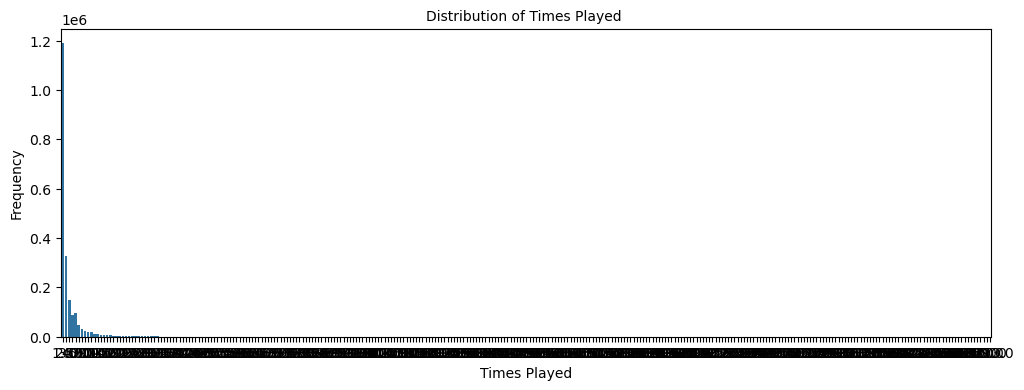

In [14]:
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x="Times Played", data=df)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Times Played ", fontsize = 10)
plt.xlabel("Times Played", fontsize = 10)
plt.ylabel("Frequency", fontsize = 10)
plt.show()

**Observations:**
- As per the histogram, a few songs are highly listened to by many users which we can assume are the popular or main stream songs, and the majority of the other songs are not listened to as frequently.
- This helps us match what some people like and see if they would like another song.

In [16]:
# Finding the number of unique users
df['User ID'].nunique()

76353

In [17]:
# Finding the number of unique songs
df['Song ID'].nunique()

10000

**Observations:**
- There are **10,000 songs** in the dataset.
- There are **76,353 users** in the dataset.

In [19]:
df.groupby(['User ID', 'Song ID']).count()

Song Title  \
User ID                                  Song ID                          
00003a4459f33b92906be11abe0e93efc423c0ff SOJJRVI12A6D4FBE49           1   
                                         SOKJWZB12A6D4F9487           1   
                                         SOMZHIH12A8AE45D00           1   
                                         SONFEUF12AAF3B47E3           1   
                                         SOVMGXI12AF72A80B0           1   
...                                                                 ...   
fffea3d509760c984e7d40789804c0e5e289cc86 SOUBKFT12A6701F07A           1   
                                         SOVPBLT12A6D4F5113           1   
                                         SOVRQIK12A6701F118           1   
                                         SOWEBRA12A6701F115           1   
                                         SOZMNAX12A58A77F88           1   

                                                             Album  Artist  \
User ID                                  Song ID                             
00003a4459f33b92906be11abe0e93efc423c0ff SOJJRVI12A6D4FBE49      1       1   
                                         SOKJWZB12A6D4F9487      1       1   
                                         SOMZHIH12A8AE45D00      1       1   
                                         SONFEUF12AAF3B47E3      1       1   
                                         SOVMGXI12AF72A80B0      1       1   
...                                                            ...     ...   
fffea3d509760c984e7d40789804c0e5e289cc86 SOUBKFT12A6701F07A      1       1   
                                         SOVPBLT12A6D4F5113      1       1   
                                         SOVRQIK12A6701F118      1       1   
                                         SOWEBRA12A6701F115      1       1   
                                         SOZMNAX12A58A77F88      1       1   

                                                             Year  \
User ID                                  Song ID                    
00003a4459f33b92906be11abe0e93efc423c0ff SOJJRVI12A6D4FBE49     1   
                                         SOKJWZB12A6D4F9487     1   
                                         SOMZHIH12A8AE45D00     1   
                                         SONFEUF12AAF3B47E3     1   
                                         SOVMGXI12AF72A80B0     1   
...                                                           ...   
fffea3d509760c984e7d40789804c0e5e289cc86 SOUBKFT12A6701F07A     1   
                                         SOVPBLT12A6D4F5113     1   
                                         SOVRQIK12A6701F118     1   
                                         SOWEBRA12A6701F115     1   
                                         SOZMNAX12A58A77F88     1   

                                                             Times Played  
User ID                                  Song ID                           
00003a4459f33b92906be11abe0e93efc423c0ff SOJJRVI12A6D4FBE49             1  
                                         SOKJWZB12A6D4F9487             1  
                                         SOMZHIH12A8AE45D00             1  
                                         SONFEUF12AAF3B47E3             1  
                                         SOVMGXI12AF72A80B0             1  
...                                                                   ...  
fffea3d509760c984e7d40789804c0e5e289cc86 SOUBKFT12A6701F07A             1  
                                         SOVPBLT12A6D4F5113             1  
                                         SOVRQIK12A6701F118             1  
                                         SOWEBRA12A6701F115             1  
                                         SOZMNAX12A58A77F88             1  

[2000000 rows x 5 columns]

In [20]:
df.groupby(['User ID', 'Song ID']).count()['Times Played'].sum()

2086946

**Observation:**
- The **sum is equal to the total number of observations**, which implies that **there is only one interaction between a song and a user**.

#### Which song was listened to the most in the dataset?

In [23]:
# Finding the most rated books in the dataset
df['Song ID'].value_counts()

Song ID
SOFRQTD12A81C233C0    8277
SOWCKVR12A8C142411    7952
SOAUWYT12A81C206F1    7032
SOAXGDH12A8C13F8A1    6949
SOBONKR12A58A7A7E0    6412
                      ... 
SOWNLZF12A58A79811      51
SOLIGVL12AB017DBAE      51
SOBPGWB12A6D4F7EF3      50
SOGSPGJ12A8C134FAA      48
SOYYBJJ12AB017E9FD      48
Name: count, Length: 10000, dtype: int64

**Observations:**
- The **Song with song_Id: SOFRQTD12A81C233C0 has been interacted by most users**( **8,277**).

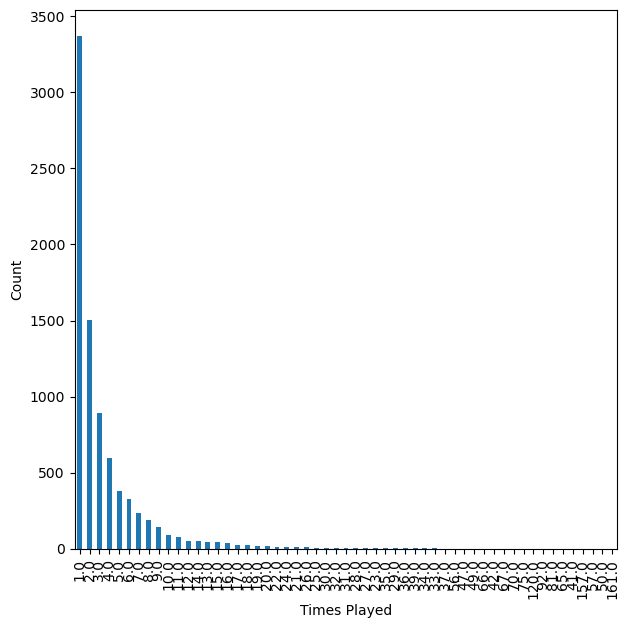

In [25]:
# Plotting distributions of ratings for the most interacted book

plt.figure(figsize=(7,7))

df[df['Song ID'] == 'SOFRQTD12A81C233C0']['Times Played'].value_counts().plot(kind='bar')

plt.xlabel('Times Played')

plt.ylabel('Count')
plt.show()

**Observations:**

- We can see that the majority of the times played for this song is less than 10 but some users have heard this song over 100 times.
- This could be a good song to leverage when trying to tie other songs to other users within our model.

In [27]:
df['User ID'].value_counts()

User ID
6d625c6557df84b60d90426c0116138b617b9449    724
fbee1c8ce1a346fa07d2ef648cec81117438b91f    687
4e11f45d732f4861772b2906f81a7d384552ad12    576
1aa4fd215aadb160965110ed8a829745cde319eb    545
24b98f8ab023f6e7a1c37c7729c623f7b821eb95    545
                                           ... 
a31bdef685c2b0da040c57a624f107ce6eccb1ca      1
dce9f5393723c084e58fa2eca06cfc512a656126      1
eb9bd44687aa837d922281ae06b8b6ac46d3a07b      1
b6552c15cedbcec2e997c5aca579e1a0f7b1055a      1
656835bcc43811f0495f1b33f40891a074882657      1
Name: count, Length: 76353, dtype: int64

**Observations:**

- The user with **user_id: 6d625c6557df84b60d90426c0116138b617b9449** has interacted with the most number of songs, i.e., **724** times.

## **Data Preparation**

In [30]:
# Get the column containing the users
users = df['User ID']
# Create a dictionary from users to find their number of songs
tp_count = dict()
for user in users:
    # If we already have the user, just add 1 to their Times Played count
    if user in tp_count:
        tp_count[user] += 1.0
    # Otherwise, set their rating count to 1
    else:
        tp_count[user] = 1.0    

In [31]:
# We want our users to have at least 50 ratings to be considered
TP_CUTOFF = 10.0
remove_users = []
for user, num_ratings in tp_count.items():
    if num_ratings < TP_CUTOFF:
        remove_users.append(user)
df = df.loc[~df['User ID'].isin(remove_users)]

In [32]:
df.shape

(1968752, 7)

In [33]:
# Get the column containing the songs
songs = df['Song ID']
# Create a dictionary from song to find their number of users
tp_count = dict()
for song in songs:
    # If we already have the song, just add 1 to their Times Played count
    if song in tp_count:
        tp_count[song] += 1.0
    # Otherwise, set their rating count to 1
    else:
        tp_count[song] = 1.0    

In [34]:
# We want our book to be interacted by at least 10 users to be considered
TP_CUTOFF = 10
remove_songs = []
for song, num_ratings in tp_count.items():
    if num_ratings < TP_CUTOFF:
        remove_songs.append(song)
df= df.loc[~df['Song ID'].isin(remove_songs)]

In [35]:
df.shape

(1968752, 7)

### **Distribution of the user-books interactions in the dataset**

In [37]:
df.nunique()

Song ID         10000
Song Title       9593
Album            5445
Artist           3379
Year               58
User ID         56584
Times Played      292
dtype: int64

In [38]:
# Finding user-songs interactions distribution
count_interactions = df.groupby('User ID').count()['Song ID']
count_interactions

User ID
0007235c769e610e3d339a17818a5708e41008d9    10
000a5c8b4d8b2c98f7a205219181d039edcd4506    14
000b474f815bcff17a4bc9ce5324f9352dafe07d    11
000d2df2cb8ad7300f89512f8fe8fadc4f99e733    11
000e2c2a8c7870ff9121f212b35c8b3a20cc0e67    59
                                            ..
fffc0df75a48d823ad5abfaf2a1ee61eb1e3302c    95
fffce9c1537fbc350ea68823d956eaa8f5236dbe    44
fffd6a2bdef646ce9898b628d5dd56c43df69a9d    11
fffd9635b33f412de8ed02e44e6564e3644cf3c6    17
fffea3d509760c984e7d40789804c0e5e289cc86    24
Name: Song ID, Length: 56584, dtype: int64

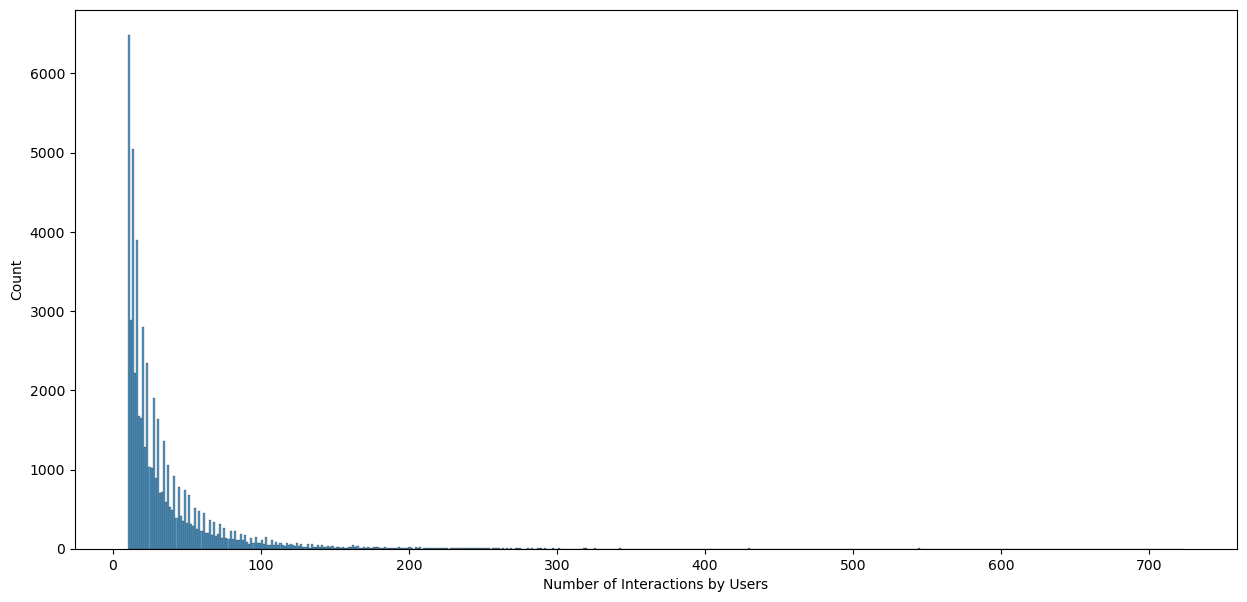

In [39]:
# Plotting user-item interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Observations:**

- The distribution is highly skewed to the left.
- It clearly shows that there are very few songs which are played beyond 100 times.

**As we have now explored the data, let's start building Recommendation Systems**

## **Model 1: Create Rank-Based Recommendation System**

- Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend book to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend songs to the new user.

- To build the rank-based recommendation system, we take average of all the ratings provided to each book and then rank them based on the number of times they have been played.

In [43]:
# Calculating Max Times Played
max_Played = df.groupby('Song ID').max()['Times Played']

# Calculating the count of Times Played
count_Played = df.groupby('Song ID').count()['Times Played']

# Making a dataframe with the count and max of times played
final_rating = pd.DataFrame({'max_tp':max_Played, 'count_tp':count_Played})

In [44]:
final_rating.head()

,max_tp,count_tp
Song ID,,
SOAAAGQ12A8C1420C8,35.0,61
SOAACPJ12A81C21360,26.0,141
SOAACSG12AB018DC80,26.0,62
SOAAEJI12AB0188AB5,12.0,59
SOAAFAC12A67ADF7EB,23.0,184


In [45]:
final_rating['count_tp'].value_counts()

count_tp
68      129
80      125
72      116
73      111
78      109
       ... 
2023      1
426       1
2126      1
519       1
921       1
Name: count, Length: 836, dtype: int64

Now, let's create a function to find the **top n songs** for a recommendation based on the max number of times a song has been played. We can also add a **threshold for a minimum number of interactions** for a songs to be considered for recommendation. 

In [47]:
def top_n_songs(data, n, min_interaction=50):
    
    # Finding books with minimum number of interactions
    recommendations = data[data['count_tp'] > min_interaction]
    
    # Sorting values w.r.t. average rating 
    recommendations = recommendations.sort_values(by='max_tp', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get books to recommend.

##### **Recommending top Songs with 50 minimum interactions based on popularity**

In [50]:
res = list(top_n_songs(final_rating, 10, 50))
# Name of the books
list_of_songs = []
for i in res:
    list_of_songs.append(df[df['Song ID']== str(i) ]['Song Title'].unique()[0])
list_of_songs

['Starshine',
 'Call It Off (Album Version)',
 'Paradise & Dreams',
 "You're The One",
 "I'm On A Boat",
 'Dance_ Dance',
 "Reelin' In The Years",
 "Can't Help But Wait (Album Version)",
 'The Quest',
 'Fast Car (LP Version)']

##### **Recommending top 5 Songs with 200 minimum interactions based on popularity**

In [52]:
res2 = list(top_n_songs(final_rating, 10, 200))
# Name of the books
list_of_song = []
for i in res2:
    list_of_song.append(df[df['Song ID']== str(i) ]['Song Title'].unique()[0])
list_of_song

['Call It Off (Album Version)',
 "You're The One",
 "I'm On A Boat",
 'Dance_ Dance',
 "Reelin' In The Years",
 "Can't Help But Wait (Album Version)",
 'Fast Car (LP Version)',
 'Glamorous',
 'Peace Train',
 'Revelry']